#Mount del drive e installazione/importazione librerie necessarie

In [ ]:
!pip install torch torchvision
!pip install rasterio
!pip install geopandas
!pip install matplotlib
!pip install albumentations
!pip install tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
percorso =  "/content/drive/MyDrive/Progetto_laboratorio"
import sys
sys.path.append(percorso)
import fiona
import os
from torch.utils.data import DataLoader, ConcatDataset

import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


Mounted at /content/drive


In [3]:
import importlib
import dataset
importlib.reload(dataset)
import model_unet
importlib.reload(model_unet)
import utils
importlib.reload(utils)
from dataset import Dataset
from model_unet import UNET
from utils import (
    save_checkpoint,
    load_checkpoint,
    calculate_metrics,
)

In [4]:
#Hyperparameters
LEARNING_RATE = [1e-2,1e-3,1e-4,1e-5]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = percorso + '/Dataset/train'
VAL_DIR = percorso + "/Dataset/validation"
TEST_DIR = percorso + "/Dataset/test"



In [5]:
#permette la riproducibilità degli esperimenti, cioè ogni volta che si esegue l'addestramento avremo gli stessi risultati
import random
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


#Training modello

In [6]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  train_loss = 0.0
  model.train()                                                    #imposta il modello in training mode
  #loader = loader_aug if use_augmentation else loader_no_aug
  loop = tqdm(loader)                                       #progress bar

  for batch_idx, (data, targets) in enumerate(loop):                       #iteriamo sui batch forniti dal loader
    if (data.shape[1] != 6 and data.shape[3] == 6):
      data = data.permute(0,3,1,2)
    if (data.shape[1] != 6 and data.shape[2] != 6):
      data = data.permute(0,2,1,3)
    data = data.to(device = DEVICE)                                      #sposta i dati sul device , CPU o GPU
    targets = targets.float().unsqueeze(1).to(device = DEVICE)             #convertiamo targets in float e aggiungiamo una dimensione extra
    # forward
    with torch.cuda.amp.autocast():                                     #abilita il mixed precision training
      predictions = model(data)                                          #calcoliamo predizioni
      loss = loss_fn(predictions, targets)                             #calcoliamo la loss

    # backward
    optimizer.zero_grad()                                                  #azzera i gradienti dell'optimizer
    scaler.scale(loss).backward()                                          #scala la loss e calcola i gradienti con backward
    scaler.step(optimizer)                                                 #aggiorna i parametri
    scaler.update()                                                        #aggiorna lo scaler

    train_loss+=loss.item()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())                                     #aggiorna il progress bar con il valore della loss

  train_loss/=len(loader)
  return train_loss



In [7]:

train_transform_aug = A.Compose([
      A.Rotate(limit=35, p=1.0),               #ruota l'immagine di un angolo casuale tra -35 e 35 gradi
      A.HorizontalFlip(p=0.5),                 #esegue un flip orizzontale dell'immagine con probabilità del 50%
      A.VerticalFlip(p=0.1),                   #esegue un flip verticale dell'immagine con probabilità del 10%
      A.Normalize(
          mean=[0.0, 0.0, 0.0],
          std=[1.0, 1.0, 1.0],
          max_pixel_value=255.0,
      ),
      ToTensorV2(),
  ], is_check_shapes=False)

train_transform_no_aug = A.Compose([
      A.Normalize(
          mean=[0.0, 0.0, 0.0],
          std=[1.0, 1.0, 1.0],
          max_pixel_value=255.0,
      ),
      ToTensorV2(),
  ], is_check_shapes=False)

val_transform = A.Compose([
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
], is_check_shapes=False)


In [9]:
#bilanciamento dataset con weightd random sampler, assegna pesi diversi ad ogni campione in base alla frequenza delle classi

train_ds_aug = dataset.Dataset(root = percorso + "/Dataset/train",transform = train_transform_aug,is_train=True)
train_ds_no_aug = dataset.Dataset(root = percorso + "/Dataset/train",transform = train_transform_no_aug,is_train=True)
val_ds = dataset.Dataset(root = percorso + "/Dataset/validation" , transform = val_transform, is_train=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=PIN_MEMORY)

print(len(train_ds_aug))
print(len(val_ds))
#Calcola le occorrenze di ogni classe
class_counts = torch.zeros(2)
mask_list = []



4334
96


In [10]:
for i in range(len(train_ds_aug)):
  _, mask = train_ds_aug[i]
  mask_list.append(mask)
  mask_tensor = torch.from_numpy(mask)
  class_counts += torch.bincount(mask_tensor.flatten(), minlength=2)

weights = 1. / class_counts.float()
weights[weights == 0] = 1e-6
weights = weights / weights.sum()
print(weights)
  # Sostituisci i valori negativi con un piccolo valore positivo

# Crea samples_weights
#samples_weights = torch.zeros(len(train_ds), dtype=torch.float)
#for i in range(len(train_ds)):
    #_, mask = train_ds[i]
 #   mask_tensor = torch.from_numpy(mask_list[i])
  #  class_weight = weights[mask_tensor.flatten().unique().to(torch.bool)]
  #  samples_weights[i] = class_weight.mean()
# Crea un sampler


#if torch.any(samples_weights <= 0):
 #   print("Ci sono valori negativi in samples_weights, li correggo...")
 #   samples_weights[samples_weights <= 0] = 1e-6
# Verifica che non ci siano valori negativi o NaN

#sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(train_ds), replacement=True)            #replacement=true permette di scegliere piu volte lo stesso campione e permette l'oversamppling per sovracampionarie le classi minoritarie

# Crea un DataLoader con il sampler
#balanced_train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=PIN_MEMORY)



tensor([0.1209, 0.8791])


In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

#Prova del modello

In [12]:
from sklearn.metrics import f1_score

def find_best_threshold(model, val_loader):
    best_threshold = 0.5
    best_f1 = 0.0
    for threshold in np.arange(0.1, 1.0, 0.1):
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)
                preds = (outputs > threshold).int()
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        f1 = f1_score(all_labels, all_preds, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

model = UNET(in_channels=6, out_channels=1).to(device = DEVICE)
best_threshold = find_best_threshold(model, val_loader)
print(best_threshold)

0.9


In [15]:

def main():
  output_dir = percorso + "/outputs"
  train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY)
  train_loader_no_aug = DataLoader(train_ds_no_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY)
  combined_dataset = ConcatDataset([train_ds_aug, train_ds_no_aug])
  train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=PIN_MEMORY)
  class_weights = weights[1] / weights[0]                 #per bilanciare le classi con 1 classe minoritaria e 0 classe maggioritaria


  model = UNET(in_channels=6, out_channels=1).to(device = DEVICE)
  loss_fn = nn.BCEWithLogitsLoss(pos_weight = class_weights).to(device = DEVICE)
  best_f1=0.0
  for lr in LEARNING_RATE:
    early_stopping = EarlyStopping(patience=5, min_delta=0.01)
    print('Proviamo lr : ',lr)
    optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-4)         #weight_decay aiuta a prevenire che i pesi diventino troppo grandi aggiungendo una 'penalità' ai pesi
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max",factor=0.1,patience=3)                 #riduce il lr di 0.1 quando il f1 score smette di migliorare con pazienza di 3 epoche
    scaler = torch.cuda.amp.GradScaler()                           #utilizzato per mixed precision training, aumenta la velocità e l'efficienza senza perdere di precisione, utilizza mix di float16 e float32
    set_seed(42)

    train_losses=[]
    val_losses=[]
    val_precisions=[]
    val_recalls=[]
    val_f1s=[]
    val_accuracies=[]
    train_precisions=[]
    train_recalls=[]
    train_f1s=[]
    train_accuracies=[]

    scaler = torch.cuda.amp.GradScaler()

    if LOAD_MODEL:
      load_checkpoint(torch.load("model.pth.tar"), model)

    all_predictions = []
    all_targets = []
    print("Training")

    for epoch in range (NUM_EPOCHS):
      train_loss=train_fn(loader=train_loader,model=model, optimizer=optimizer, loss_fn=loss_fn, scaler=scaler)

      train_losses.append(train_loss)

      val_loss= 0.0
      with torch.no_grad():
        for images,labels in val_loader:
          images = images.to(DEVICE)
          labels = labels.float().unsqueeze(1).to(DEVICE)
          outputs = model(images)
          loss = loss_fn(outputs,labels)
          val_loss+=loss.item()

        val_loss/=len(val_loader)
        val_losses.append(val_loss)

      accuracy_val,precision_val,recall_val,f1_val = calculate_metrics(val_loader,model,best_threshold,False,DEVICE)
      val_precisions.append(precision_val)
      val_recalls.append(recall_val)
      val_f1s.append(f1_val)
      val_accuracies.append(accuracy_val)

      #accuracy_train,precision_train,recall_train,f1_train = calculate_metrics(train_loader_no_aug,model,best_threshold,True,DEVICE)
      #train_precisions.append(precision_train)
      #train_recalls.append(recall_train)
      #train_f1s.append(f1_train)
      #train_accuracies.append(accuracy_train)

      print('train loss: ',train_loss)
      print('val_loss : ',val_loss)
      #print('train accuracy : ',accuracy_train*100)
      #print('train precision : ',precision_train)
      #print('train recall : ', recall_train)
      #print('train f1 : ', f1_train)
      print('val accuracy : ',accuracy_val*100)
      print('val precision : ',precision_val)
      print('val recall : ', recall_val)
      print('val f1 : ', f1_val)

      if f1_val > best_f1:
        best_f1 = f1_val
        print(f"Nuovo miglior F1-score: {best_f1}. Salvataggio del modello...")
        model_save_name = 'best_model.pth'
        path = F"/content/drive/MyDrive/Progetto_laboratorio/{model_save_name}"
        torch.save(model.state_dict(), path)

      scheduler.step(f1_val)
      early_stopping(f1_val)

      if early_stopping.early_stop:
        print("Early stopping")
        break
    print(best_f1)
    plot_and_save_metrics(train_losses, val_losses, train_precisions, val_precisions, train_recalls, val_recalls, train_accuracies, val_accuracies, train_f1s, val_f1s, lr, output_dir)


Proviamo lr :  0.01
Training


100%|██████████| 113/113 [02:21<00:00,  1.26s/it, loss=0.652]


[[6242579    2218]
 [  44325    2334]]
train loss:  0.8358061445497833
val_loss :  0.436776340007782
val accuracy :  99.26022291183472
val precision :  0.5127416520210897
val recall :  0.05002250369703594
val f1 :  0.09115229149987306
Nuovo miglior F1-score: 0.09115229149987306. Salvataggio del modello...


100%|██████████| 113/113 [02:24<00:00,  1.28s/it, loss=0.64]


[[6242646    2151]
 [  46645      14]]
train loss:  0.7234331886325263
val_loss :  0.41519707441329956
val accuracy :  99.22441244125366
val precision :  0.006466512702078522
val recall :  0.0003000492938125549
val f1 :  0.0005734884483041126


100%|██████████| 113/113 [02:20<00:00,  1.25s/it, loss=0.66]


[[6236021    8776]
 [  44150    2509]]
train loss:  0.6649599935101197
val_loss :  0.4130641222000122
val accuracy :  99.15876388549805
val precision :  0.22233052724856003
val recall :  0.05377311986969288
val f1 :  0.0866008559988955


100%|██████████| 113/113 [02:22<00:00,  1.26s/it, loss=0.629]


[[6243011    1786]
 [  44637    2022]]
train loss:  0.6291991258616996
val_loss :  0.36018067598342896
val accuracy :  99.26213026046753
val precision :  0.5309873949579832
val recall :  0.043335690863499005
val f1 :  0.0801315711256861


100%|██████████| 113/113 [02:18<00:00,  1.22s/it, loss=0.609]


[[6240310    4487]
 [  45976     683]]
train loss:  0.6291868436125527
val_loss :  0.43424534797668457
val accuracy :  99.19791221618652
val precision :  0.1321083172147002
val recall :  0.014638119119569644
val f1 :  0.026355901136429414


100%|██████████| 113/113 [02:20<00:00,  1.24s/it, loss=0.549]


[[6238482    6315]
 [  45777     882]]
train loss:  0.5791624816118088
val_loss :  0.40389037132263184
val accuracy :  99.1720199584961
val precision :  0.12255106294289288
val recall :  0.01890310551019096
val f1 :  0.032754010695187165
Early stopping
0.09115229149987306


ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

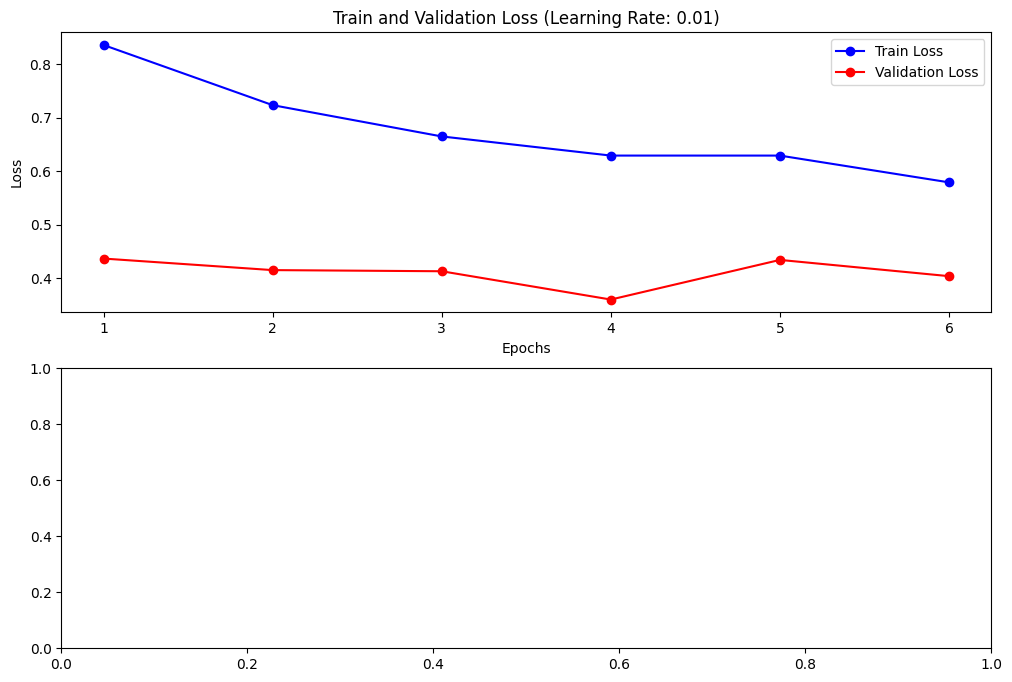

In [16]:

if __name__ == "__main__":
  try:
      torch.multiprocessing.set_start_method('spawn', force=True)
  except RuntimeError:
      pass
  torch.cuda.empty_cache()
  main()


In [8]:
import os
import matplotlib.pyplot as plt

def plot_and_save_metrics(train_losses, val_losses, train_precisions, val_precisions, train_recalls, val_recalls, train_accuracies, val_accuracies, train_f1s, val_f1s, learning_rate, output_dir):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))

    # Plot train and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title(f'Train and Validation Loss (Learning Rate: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot precision, recall, accuracy, and F1-score
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_precisions, 'b-', label='Train Precision')
    plt.plot(epochs, val_precisions, 'g-', label='Validation Precision')
    plt.plot(epochs, train_recalls, 'm-', label='Train Recall')
    plt.plot(epochs, val_recalls, 'r-', label='Validation Recall')
    plt.plot(epochs, train_accuracies, 'c-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'y-', label='Validation Accuracy')
    plt.plot(epochs, train_f1s, 'k-', label='Train F1-score')
    plt.plot(epochs, val_f1s, 'orange', label='Validation F1-score')
    plt.title(f'Train and Validation Metrics (Learning Rate: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.tight_layout()

    # Save the plot
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, f'metrics_lr_{learning_rate}.png'))
    plt.close()



In [ ]:
model = UNET(in_channels=6, out_channels=1).to(device=DEVICE)

# Carica i pesi salvati
model.load_state_dict(torch.load(percorso + '/best_model.pth'))
model.eval()  # Imposta il modello in modalità di valutazione

test_ds = dataset.Dataset(root=percorso + "/Dataset/test", transform=None)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=PIN_MEMORY)

def evaluate_model(loader, model, device):
    model.eval()

    accuracy, precision, recall, f1 = calculate_metrics(test_loader, model)
    return accuracy, precision, recall, f1

# Valuta il modello sul test set
accuracy, precision, recall, f1 = evaluate_model(test_loader, model, DEVICE)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

[[5672054  550007]
 [  35068   34327]]
Test Accuracy: 90.70%
Test Precision: 0.0587
Test Recall: 0.4947
Test F1-score: 0.1050


In [ ]:
output_dir = percorso + "/outputs"
import matplotlib.pyplot as plt
import os

def plot_and_save_metrics_test(metrics, output_dir='outputs'):
    # Assicurati che la cartella di output esista
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Nomi delle metriche
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    # Crea i grafici
    plt.figure(figsize=(10, 5))
    plt.bar(metric_names, metrics, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Model Performance on Test Set')

    # Salva il grafico nella cartella di output
    output_path = os.path.join(output_dir, 'model_performance_metrics.png')
    plt.savefig(output_path)
    plt.close()

    print(f"Metrics plot saved to {output_path}")

# Esempio di utilizzo
# Supponiamo che tu abbia già calcolato le metriche
metrics = accuracy, precision, recall, f1  # Esempio di valori per accuracy, precision, recall, F1-score
plot_and_save_metrics(metrics)
